## ILDAR AGLIUKOV LSML2 FINAL PROJECT
## MULTY STYLE TRANSFER

In [ ]:
!apt-get install wget
!apt-get install unzip

#### We will use COCO dataset and our we can choose from multy style

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip

In [ ]:
!unzip /content/train2014.zip 
!unzip /content/val2014.zip

### part of code borrowed [hear](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) and other resources

In [ ]:
import numpy as np
from torchvision import transforms

import os
import sys
import time
import numpy as np
from tqdm import tqdm, trange

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets



def var(x, dim=0):
    '''
    Calculates variance.
    '''
    x_zero_meaned = x - x.mean(dim).expand_as(x)
    return x_zero_meaned.pow(2).mean(dim)


class MultConst(nn.Module):
    def forward(self, input):
        return 255*input


class GramMatrix(nn.Module):
    def forward(self, y):
        (b, ch, h, w) = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram
    

class Basicblock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=nn.BatchNorm2d):
        super(Basicblock, self).__init__()
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes,
                                                        kernel_size=1, stride=stride)
        conv_block=[]
        conv_block+=[norm_layer(inplanes),
                                nn.ReLU(inplace=True),
                                ConvLayer(inplanes, planes, kernel_size=3, stride=stride),
                                norm_layer(planes),
                                nn.ReLU(inplace=True),
                                ConvLayer(planes, planes, kernel_size=3, stride=1),
                                norm_layer(planes)]
        self.conv_block = nn.Sequential(*conv_block)
    
    def forward(self, input):
        if self.downsample is not None:
            residual = self.residual_layer(input)
        else:
            residual = input
        return residual + self.conv_block(input)
            

class UpBasicblock(nn.Module):
    """ Up-sample residual block (from MSG-Net paper)
    Enables passing identity all the way through the generator
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, inplanes, planes, stride=2, norm_layer=nn.BatchNorm2d):
        super(UpBasicblock, self).__init__()
        self.residual_layer = UpsampleConvLayer(inplanes, planes,
                                                      kernel_size=1, stride=1, upsample=stride)
        conv_block=[]
        conv_block+=[norm_layer(inplanes),
                                nn.ReLU(inplace=True),
                                UpsampleConvLayer(inplanes, planes, kernel_size=3, stride=1, upsample=stride),
                                norm_layer(planes),
                                nn.ReLU(inplace=True),
                                ConvLayer(planes, planes, kernel_size=3, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)
    
    def forward(self, input):
        return self.residual_layer(input) + self.conv_block(input)


class Bottleneck(nn.Module):
    """ Pre-activation residual block
    Identity Mapping in Deep Residual Networks
    ref https://arxiv.org/abs/1603.05027
    """
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=nn.BatchNorm2d):
        super(Bottleneck, self).__init__()
        self.expansion = 4
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes * self.expansion,
                                                        kernel_size=1, stride=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    ConvLayer(planes, planes, kernel_size=3, stride=stride)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)
        
    def forward(self, x):
        if self.downsample is not None:
            residual = self.residual_layer(x)
        else:
            residual = x
        return residual + self.conv_block(x)


class UpBottleneck(nn.Module):
    """ Up-sample residual block (from MSG-Net paper)
    Enables passing identity all the way through the generator
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, inplanes, planes, stride=2, norm_layer=nn.BatchNorm2d):
        super(UpBottleneck, self).__init__()
        self.expansion = 4
        self.residual_layer = UpsampleConvLayer(inplanes, planes * self.expansion,
                                                      kernel_size=1, stride=1, upsample=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    UpsampleConvLayer(planes, planes, kernel_size=3, stride=1, upsample=stride)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return  self.residual_layer(x) + self.conv_block(x)


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        self.reflection_padding = int(np.floor(kernel_size / 2))
        if self.reflection_padding != 0:
            self.reflection_pad = nn.ReflectionPad2d(self.reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample_layer(x)
        if self.reflection_padding != 0:
            x = self.reflection_pad(x)
        out = self.conv2d(x)
        return out


class Inspiration(nn.Module):
    """ Inspiration Layer (from MSG-Net paper)
    tuning the featuremap with target Gram Matrix
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, C, B=1):
        super(Inspiration, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1,C,C), requires_grad=True)
        self.G = Variable(torch.Tensor(B,C,C), requires_grad=True)
        self.C = C
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.uniform_(0.0, 0.02)

    def setTarget(self, target):
        self.G = target

    def forward(self, X):
        # input X is a 3D feature map
        self.P = torch.bmm(self.weight.expand_as(self.G),self.G)
        return torch.bmm(self.P.transpose(1,2).expand(X.size(0), self.C, self.C), X.view(X.size(0),X.size(1),-1)).view_as(X)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'N x ' + str(self.C) + ')'


class Vgg16(torch.nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

    def forward(self, X):
        h = F.relu(self.conv1_1(X))
        h = F.relu(self.conv1_2(h))
        relu1_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv2_1(h))
        h = F.relu(self.conv2_2(h))
        relu2_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv3_1(h))
        h = F.relu(self.conv3_2(h))
        h = F.relu(self.conv3_3(h))
        relu3_3 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv4_1(h))
        h = F.relu(self.conv4_2(h))
        h = F.relu(self.conv4_3(h))
        relu4_3 = h

        return [relu1_2, relu2_2, relu3_3, relu4_3]


class Net(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, n_blocks=6, gpu_ids=[]):
        super(Net, self).__init__()
        self.gpu_ids = gpu_ids
        self.gram = GramMatrix()

        block = Bottleneck
        upblock = UpBottleneck
        expansion = 4

        model1 = []
        model1 += [ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                            norm_layer(64),
                            nn.ReLU(inplace=True),
                            block(64, 32, 2, 1, norm_layer),
                            block(32*expansion, ngf, 2, 1, norm_layer)]
        self.model1 = nn.Sequential(*model1)

        model = []
        self.ins = Inspiration(ngf*expansion)
        model += [self.model1]
        model += [self.ins]    

        for i in range(n_blocks):
            model += [block(ngf*expansion, ngf, 1, None, norm_layer)]
        
        model += [upblock(ngf*expansion, 32, 2, norm_layer),
                            upblock(32*expansion, 16, 2, norm_layer),
                            norm_layer(16*expansion),
                            nn.ReLU(inplace=True),
                            ConvLayer(16*expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def setTarget(self, Xs):
        F = self.model1(Xs)
        G = self.gram(F)
        self.ins.setTarget(G)

    def forward(self, input):
        return self.model(input)

In [ ]:
import os

import numpy as np
import torch
from PIL import Image
from torch.autograd import Variable


def tensor_load_rgbimage(filename, size=None, scale=None, keep_asp=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if keep_asp:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)

    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img


def tensor_save_rgbimage(tensor, filename, cuda=False):
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)


def tensor_save_bgrimage(tensor, filename, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename, cuda)


def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def subtract_imagenet_mean_batch(batch):
    """Subtract ImageNet mean pixel-wise from a BGR image."""
    tensortype = type(batch.data)
    mean = tensortype(batch.data.size())
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    return batch - Variable(mean)


def add_imagenet_mean_batch(batch):
    """Add ImageNet mean pixel-wise from a BGR image."""
    tensortype = type(batch.data)
    mean = tensortype(batch.data.size())
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    return batch + Variable(mean)

def imagenet_clamp_batch(batch, low, high):
    batch[:,0,:,:].data.clamp_(low-103.939, high-103.939)
    batch[:,1,:,:].data.clamp_(low-116.779, high-116.779)
    batch[:,2,:,:].data.clamp_(low-123.680, high-123.680)


def preprocess_batch(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

class StyleLoader():
    def __init__(self, style_folder, style_size, cuda=True):
        self.folder = style_folder
        self.style_size = style_size
        self.files = os.listdir(style_folder)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    def get(self, i):
        idx = i%len(self.files)
        filepath = os.path.join(self.folder, self.files[idx])
        style = tensor_load_rgbimage(filepath, self.style_size)    
        style = style.unsqueeze(0)
        style = preprocess_batch(style).to(self.device)
        style_v = Variable(style, requires_grad=False)
        return style_v

    def size(self):
        return len(self.files)

In [ ]:
def train_model(epochs=4,
          vgg=None,
          batch_size=8,
          train_loader=None,
          style_folder='/content/styles',
          save_model_dir='/content/',
          image_size=512,
          style_size=512,
          device='cpu',
          log_interval=500,
          ngf=128,
          lr=1e-3,
          content_weight=1.0,
          style_weight=1.0,
          seed=42):

    np.random.seed(seed)
    torch.manual_seed(seed)

    if device == 'cuda':
        torch.cuda.manual_seed(seed)
        kwargs = {'num_workers': 0, 'pin_memory': False}
    else:
        kwargs = {}

    style_model = Net(ngf=ngf)
    optimizer = Adam(style_model.parameters(), lr)
    mse_loss = torch.nn.MSELoss()

    vgg = vgg
    style_model.to(device)
    vgg.to(device)

    style_loader = StyleLoader(style_folder, style_size)

    tbar = trange(epochs)
    for e in tbar:
        style_model.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()
            x = Variable(preprocess_batch(x))
            x = x.to(device)

            style_v = style_loader.get(batch_id)
            style_model.setTarget(style_v)

            style_v = subtract_imagenet_mean_batch(style_v.to('cpu')).to(device)
            features_style = vgg(style_v)
            gram_style = [gram_matrix(y) for y in features_style]

            y = style_model(x)
            xc = Variable(x.data.clone())

            y = subtract_imagenet_mean_batch(y.to('cpu')).to(device)
            xc = subtract_imagenet_mean_batch(xc.to('cpu')).to(device)

            features_y = vgg(y)
            features_xc = vgg(xc)

            f_xc_c = Variable(features_xc[1].data, requires_grad=False)

            content_loss = content_weight * mse_loss(features_y[1], f_xc_c)

            style_loss = 0.
            for m in range(len(features_y)):
                gram_y = gram_matrix(features_y[m])
                gram_s = Variable(gram_style[m].data, requires_grad=False).repeat(batch_size, 1, 1, 1)
                style_loss += style_weight * mse_loss(gram_y, gram_s[:n_batch, :, :])

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                agg_content_loss / (batch_id + 1),
                                agg_style_loss / (batch_id + 1),
                                (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                tbar.set_description(mesg)

            
            if (batch_id + 1) % (4 * log_interval) == 0:
                # save model
                style_model.eval()
                style_model.cpu()
                save_model_filename = "Epoch_" + str(e) + "iters_" + str(count) + "_" + \
                    str(time.ctime()).replace(' ', '_') + "_" + str(
                    content_weight) + "_" + str(style_weight) + ".model"
                save_model_path = os.path.join(save_model_dir, save_model_filename)
                torch.save(style_model.state_dict(), save_model_path)
                style_model.train()
                style_model.cuda()
                tbar.set_description("\nCheckpoint, trained model saved at", save_model_path)

    final_loss = (agg_content_loss + agg_style_loss) / (batch_id + 1)
    # save model
    style_model.eval()
    style_model.cpu()
    save_model_filename = "Final_epoch_" + str(epochs) + "_" + \
        str(time.ctime()).replace(' ', '_') + "_" + str(
        content_weight) + "_" + str(style_weight) + ".model"
    save_model_path = os.path.join(save_model_dir, save_model_filename)
    torch.save(style_model.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)
    return final_loss 

In [ ]:
epochs=4
batch_size=8
image_size=512
style_size=512
ngf=128
lr=1e-3
content_weight=1.0
style_weight=1.0

transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(256),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.mul(255))])
train_dataset = datasets.ImageFolder('/content/images', transform)
train_loader = DataLoader(train_dataset, batch_size=4)

We will copy some pretrained layers from VGG

In [62]:
import torchvision.models as models
vgg = Vgg16()

## I will train image of size 128 because i haven't enough time to train neural netrowk

In [ ]:
loss = train_model(vgg=vgg,
            epochs=epochs,
            batch_size=batch_size,
            image_size=image_size,
            style_size=style_size,
            ngf=ngf,
            lr=lr,
            content_weight=content_weight,
            style_weight=style_weight,
            train_loader=train_loader,
            device='cuda')

In [43]:
model = Net(ngf=128)
model.load_state_dict(torch.load('/content/Final_epoch_4_Sun_May__8_12:18:22_2022_1.0_1.0.model'))
model.eval()

In [48]:
img = Image.open('/content/styles/starry_night.jpg').convert('RGB')
img = img.resize((512, 512), Image.ANTIALIAS)
img = np.array(img).transpose(2, 0, 1)
img = torch.FloatTensor(img).unsqueeze(0)
batch = img.transpose(0, 1)
(r, g, b) = torch.chunk(batch, 3)
batch = torch.cat((b, g, r))
batch = batch.transpose(0, 1)
style_v = Variable(batch, requires_grad=False)
model.setTarget(style_v)

In [57]:
img = cv2.resize(cv2.imread('/content/Interstellar_1547650273.jpg'), (128, 128))

In [60]:
img = Image.open('/content/Interstellar_1547650273.jpg').convert('RGB')

## Original image

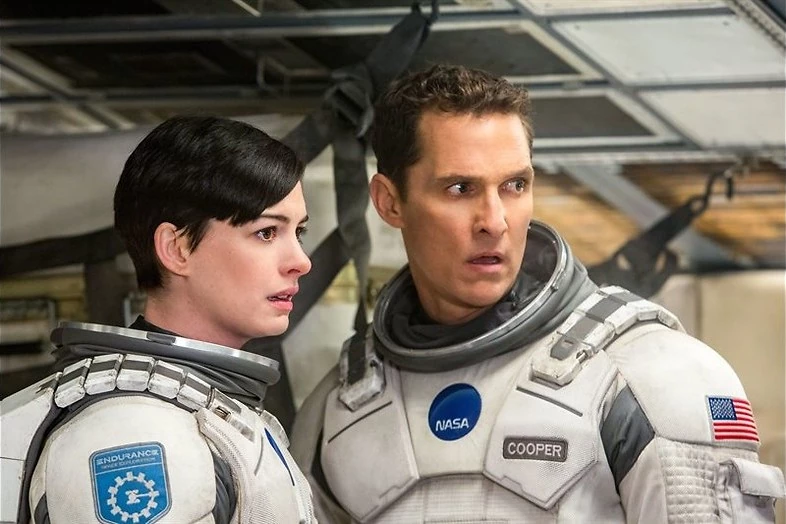

In [61]:
img 

In [53]:
img = cv2.resize(cv2.imread('/content/Interstellar_1547650273.jpg'), (128, 128))
img = torch.FloatTensor(img).permute((2, 1, 0)).unsqueeze(0)

# First style

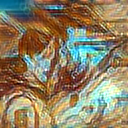

In [50]:
model.setTarget(style_v.to('cpu'))
Image.fromarray(np.uint8(model(img)[0].clamp(0, 255).detach().permute((2, 1, 0)).to(int).numpy()))

## Second Style

In [51]:
img = Image.open('/content/styles/candy.jpg').convert('RGB')
img = img.resize((512, 512), Image.ANTIALIAS)
img = np.array(img).transpose(2, 0, 1)
img = torch.FloatTensor(img).unsqueeze(0)
batch = img.transpose(0, 1)
(r, g, b) = torch.chunk(batch, 3)
batch = torch.cat((b, g, r))
batch = batch.transpose(0, 1)
style_v = Variable(batch, requires_grad=False)
model.setTarget(style_v)

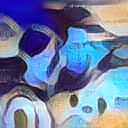

In [54]:
model.setTarget(style_v.to('cpu'))
Image.fromarray(np.uint8(model(img)[0].clamp(0, 255).detach().permute((2, 1, 0)).to(int).numpy()))

## MLFLOG log

In [ ]:
import mlflow

MLFLOW_SERVER_URL = 'http://mlflow:5000/'
mlflow.set_tracking_uri(MLFLOW_SERVER_URL)

# run experiment

experiment_name = 'gen_new_exp'
mlflow.set_experiment(experiment_name)

mlflow.end_run()
with mlflow.start_run():
    mlflow.log_param('epochs', epochs])
    mlflow.log_param('batch_size', batch_size])
    mlflow.log_param('image_size', image_size)
    mlflow.log_param('style_size', style_size)
    mlflow.log_param('ngf', ngf)
    mlflow.log_param('lr', lr)
    mlflow.log_param('content_weight', content_weight)
    mlflow.log_param('style_weight', style_weight)
    mlflow.log_metric('train_loss', loss)
    mlflow.pytorch.log_model(model, "model")